This notebook will look for the following pattern:
- WT not associated with time.
    - P > 0.05 and abs log2FC < log2(1.5)
- MUT associated with time.
    - P < 0.05 and abs log2FC > 1

The bottom line is that no comparison is taken between WT and MUT at neither initial nor last time points. So, if initial conditions do not match it is OK and also, situations such that MUT reaches the flat WT are also OK.

In [1]:
import pandas, numpy, termcolor, seaborn
import scipy, scipy.stats

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

# 0. user-defined variables

In [3]:
DEG_folder = '/home/adrian/projects/reynisfjara/results/DEGs_DESeq2/strict/'
expression_file = '/home/adrian/projects/reynisfjara/results/tpm/DESeq2_TPM_values.tsv'

annotation_file = '/home/adrian/projects/reynisfjara/results/annotation/annotation.csv'
dorothea_file = '/home/adrian/software/dorothea/mmusculus/mmusculus.dorothea.txt'

mice = ['a3922', 'a4774', 'a4775', 'a4776']
times = ['0h', '48h', '72h']
numerical_times = [0, 48, 72]

# 1. read data

## 1.1. read expression

In [4]:
expression = pandas.read_csv(expression_file, sep='\t', index_col=0)
expression.head()

,a3922_0h_1,a3922_0h_2,a3922_0h_3,a3922_48h_1,a3922_48h_2,a3922_48h_3,a3922_72h_1,a3922_72h_2,a3922_72h_3,a4774_0h_1,...,a4775_72h_3,a4776_0h_1,a4776_0h_2,a4776_0h_3,a4776_48h_1,a4776_48h_2,a4776_48h_3,a4776_72h_1,a4776_72h_2,a4776_72h_3
ENSMUSG00000000001,65.244411,65.953285,64.396929,75.289955,71.147817,72.146832,67.786762,70.217188,70.219265,61.227221,...,68.440778,64.806231,65.619286,66.749396,64.425407,68.665136,68.419059,69.705546,70.717428,71.017699
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.945436,5.464240,4.924612,20.245428,19.780706,22.747363,19.239938,22.062649,20.547492,7.843197,...,14.565935,4.712688,3.690099,4.120889,7.220914,8.377850,9.611563,9.465468,10.235803,9.808747
ENSMUSG00000000037,0.220972,0.959207,0.258270,0.969948,1.149452,2.212842,0.989879,2.354492,1.813624,0.545637,...,0.989086,0.451844,0.523639,0.679725,2.862086,0.865126,1.973570,1.612622,2.148935,5.445061
ENSMUSG00000000049,0.061451,0.061879,0.096945,0.000000,0.071373,0.000000,0.059768,0.000000,0.000000,0.214027,...,0.761343,0.000000,0.125876,0.000000,0.000000,0.096454,0.130578,0.000000,0.000000,0.000000


## 1.2. read annotation

In [5]:
annotation = pandas.read_csv(annotation_file, sep=',', index_col='ens_gene')
annotation.drop(columns=['Unnamed: 0', 'target_id'], inplace=True)
annotation.drop_duplicates(inplace=True)
print(annotation.shape)
annotation.head()

(53193, 3)


,gene_biotype,description,ext_gene
ens_gene,,,
ENSMUSG00000064336,Mt_tRNA,mitochondrially encoded tRNA phenylalanine [So...,mt-Tf
ENSMUSG00000064337,Mt_rRNA,mitochondrially encoded 12S rRNA [Source:MGI S...,mt-Rnr1
ENSMUSG00000064338,Mt_tRNA,mitochondrially encoded tRNA valine [Source:MG...,mt-Tv
ENSMUSG00000064339,Mt_rRNA,mitochondrially encoded 16S rRNA [Source:MGI S...,mt-Rnr2
ENSMUSG00000064340,Mt_tRNA,mitochondrially encoded tRNA leucine 1 [Source...,mt-Tl1


## 1.3. read Dorothea

# 2. transform expression to be more amenable to downstream analysis

In [6]:
df = pandas.DataFrame()
for mouse in mice:
    for time in times:
        condition_labels = [label for label in expression.columns if mouse in label and time in label]
        df[mouse + '_' + time] = expression.loc[:, condition_labels].median(axis=1)
df.head()

,a3922_0h,a3922_48h,a3922_72h,a4774_0h,a4774_48h,a4774_72h,a4775_0h,a4775_48h,a4775_72h,a4776_0h,a4776_48h,a4776_72h
ENSMUSG00000000001,65.244411,72.146832,70.217188,61.227221,65.197716,64.804086,55.869249,65.371837,68.440778,65.619286,68.419059,70.717428
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.464240,20.245428,20.547492,7.843197,8.262456,11.467644,8.258439,15.989181,16.179836,4.120889,8.377850,9.808747
ENSMUSG00000000037,0.258270,1.149452,1.813624,0.567393,1.344796,1.122762,0.472029,0.958435,1.713961,0.523639,1.973570,2.148935
ENSMUSG00000000049,0.061879,0.000000,0.000000,0.214027,0.000000,0.000000,0.149524,0.000000,0.441745,0.000000,0.096454,0.000000


In [7]:
for label in df.columns:
    if 'a3922' in label:
        new_label = 'WT_' + label.split('_')[1]
        df.rename(columns = {label:new_label}, inplace=True)
df.head()

,WT_0h,WT_48h,WT_72h,a4774_0h,a4774_48h,a4774_72h,a4775_0h,a4775_48h,a4775_72h,a4776_0h,a4776_48h,a4776_72h
ENSMUSG00000000001,65.244411,72.146832,70.217188,61.227221,65.197716,64.804086,55.869249,65.371837,68.440778,65.619286,68.419059,70.717428
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.464240,20.245428,20.547492,7.843197,8.262456,11.467644,8.258439,15.989181,16.179836,4.120889,8.377850,9.808747
ENSMUSG00000000037,0.258270,1.149452,1.813624,0.567393,1.344796,1.122762,0.472029,0.958435,1.713961,0.523639,1.973570,2.148935
ENSMUSG00000000049,0.061879,0.000000,0.000000,0.214027,0.000000,0.000000,0.149524,0.000000,0.441745,0.000000,0.096454,0.000000


In [8]:
simple_expression = df.iloc[:, :3]
simple_expression.head()

,WT_0h,WT_48h,WT_72h
ENSMUSG00000000001,65.244411,72.146832,70.217188
ENSMUSG00000000003,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.464240,20.245428,20.547492
ENSMUSG00000000037,0.258270,1.149452,1.813624
ENSMUSG00000000049,0.061879,0.000000,0.000000


In [9]:
simple_expression = df.iloc[:, :3]

for time in times:
    condition_labels = [label for label in df.columns if time in label and 'WT' not in label]
    simple_expression['MUT_' + time] = df.loc[:, condition_labels].median(axis=1)

simple_expression.head()

,WT_0h,WT_48h,WT_72h,MUT_0h,MUT_48h,MUT_72h
ENSMUSG00000000001,65.244411,72.146832,70.217188,61.227221,65.371837,68.440778
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.464240,20.245428,20.547492,7.843197,8.377850,11.467644
ENSMUSG00000000037,0.258270,1.149452,1.813624,0.523639,1.344796,1.713961
ENSMUSG00000000049,0.061879,0.000000,0.000000,0.149524,0.000000,0.000000


# 3. search for pattern

## 3.1. retrieve genes that change with time in MUT phenotype

In [10]:
DEGs = []
for mouse in mice[1:]:
    path = DEG_folder + 'strict_MUTt72_over_MUTt0_' + mouse + '.tsv'
    df = pandas.read_csv(path, sep='\t', index_col=0)
    print(df.shape)
    DEGs.append(df.index.to_list())
list_one = list(set(DEGs[0]) & set(DEGs[1]) & set(DEGs[2]))
print(len(list_one))

(468, 6)
(1049, 6)
(1056, 6)
218


In [11]:
# filter out genes that do not cross the abs log2FC > 1 and the max. expr. > 2
list_one_a = []
for ensembl in list_one:
    working_expression = simple_expression.loc[ensembl, :]
    #print(working_expression)
    start = numpy.round(simple_expression.loc[ensembl, 'MUT_0h']) + 1
    end = numpy.round(simple_expression.loc[ensembl, 'MUT_72h']) + 1
    #print(start, end)
    abs_log2FC = numpy.abs(numpy.log2(end/start))
    #print(abs_log2FC)
    
    max_expr = numpy.max([start, end])
    
    if abs_log2FC > 1 and max_expr > 2+1:
        list_one_a.append(ensembl)
        
print(len(list_one_a))

142


## 3.2. check that genes are WT flat

In [12]:
path = DEG_folder + 'strict_WTt72_over_WTt0' + '.tsv'
df = pandas.read_csv(path, sep='\t', index_col=0)
print(df.shape)
DEGs = df.index.to_list()
list_four = list(set(DEGs))
print(len(list_four))

(1383, 6)
1383


In [13]:
# a flat gene is a gene that:
# if has low expression (TPM < 2)
# elif abs log2FC < log(1.5) and not in significant group

list_four_a = []
for ensembl in simple_expression.index:
    start = numpy.round(simple_expression.loc[ensembl, 'WT_0h']) + 1
    end = numpy.round(simple_expression.loc[ensembl, 'WT_72h']) + 1
    max_expr = numpy.max([start, end])
    abs_log2FC = numpy.abs(numpy.log2(end/start))
    
    if max_expr < 2+1:
        list_four_a.append(ensembl)
    if abs_log2FC < numpy.log2(1.5) and ensembl not in list_four:
        list_four_a.append(ensembl)
        
list_four_b = list(set(list_four_a))
print(len(simple_expression.index), len(list_four_a), len(list_four_b))

35938 56784 33227


## 3.3. define gene set such that MUT changes and WT does not

In [14]:
list_five = []
for ensembl in list_one_a:
    if ensembl in list_four_b:
        list_five.append(ensembl)
print(len(list_five))

31


# 4. plot and print identified genes

## 4.1. print selected set of genes

In [15]:
for ensembl in list_five:
    print(ensembl)

ENSMUSG00000036698
ENSMUSG00000009687
ENSMUSG00000028713
ENSMUSG00000015766
ENSMUSG00000030084
ENSMUSG00000047793
ENSMUSG00000020190
ENSMUSG00000016496
ENSMUSG00000036853
ENSMUSG00000026857
ENSMUSG00000035273
ENSMUSG00000107874
ENSMUSG00000028194
ENSMUSG00000025511
ENSMUSG00000032564
ENSMUSG00000068220
ENSMUSG00000029510
ENSMUSG00000059013
ENSMUSG00000029861
ENSMUSG00000072941
ENSMUSG00000022243
ENSMUSG00000023009
ENSMUSG00000030796
ENSMUSG00000074892
ENSMUSG00000021696
ENSMUSG00000006235
ENSMUSG00000001751
ENSMUSG00000037049
ENSMUSG00000003617
ENSMUSG00000014444
ENSMUSG00000046727


This gives a small (3/22) but significant (P < 8e-3) enrichment on the term [HS-GAG degradation](https://reactome.org/content/detail/R-HSA-2024096), lysosomal degradation of glycosaminoglycans.

In [16]:
index = 0
for ensembl in list_five:
    index = index + 1
    gene_name = annotation.loc[ensembl]['ext_gene']
    description = annotation.loc[ensembl]['description'].split(' [')[0]
    if simple_expression.loc[ensembl, 'MUT_72h'] > simple_expression.loc[ensembl, 'MUT_0h']:
        trend = 'up'
        message = '\t'.join([str(index), ensembl, gene_name, trend, description])
        print(termcolor.colored(message, 'red'))
    else:
        trend = 'down'
        message = '\t'.join([str(index), ensembl, gene_name, trend, description])
        print(termcolor.colored(message, 'blue'))

1	ENSMUSG00000036698	Ago2	down	argonaute RISC catalytic subunit 2
2	ENSMUSG00000009687	Fxyd5	down	FXYD domain-containing ion transport regulator 5
3	ENSMUSG00000028713	Cyp4b1	up	cytochrome P450, family 4, subfamily b, polypeptide 1
4	ENSMUSG00000015766	Eps8	down	epidermal growth factor receptor pathway substrate 8
5	ENSMUSG00000030084	Plxna1	down	plexin A1
6	ENSMUSG00000047793	Sned1	up	sushi, nidogen and EGF-like domains 1
7	ENSMUSG00000020190	Mknk2	down	MAP kinase-interacting serine/threonine kinase 2
8	ENSMUSG00000016496	Cd274	up	CD274 antigen
9	ENSMUSG00000036853	Mcoln3	down	mucolipin 3
10	ENSMUSG00000026857	Ntmt1	down	N-terminal Xaa-Pro-Lys N-methyltransferase 1
11	ENSMUSG00000035273	Hpse	down	heparanase
12	ENSMUSG00000107874	Prpmp5	down	proline-rich protein MP5
13	ENSMUSG00000028194	Ddah1	down	dimethylarginine dimethylaminohydrolase 1
14	ENSMUSG00000025511	Tspan4	down	tetraspanin 4
15	ENSMUSG00000032564	Cpne4	down	copine IV
16	ENSMUSG00000068220	Lgals1	down	lectin, galactose bindi

## 4.2. generate trajectory plots

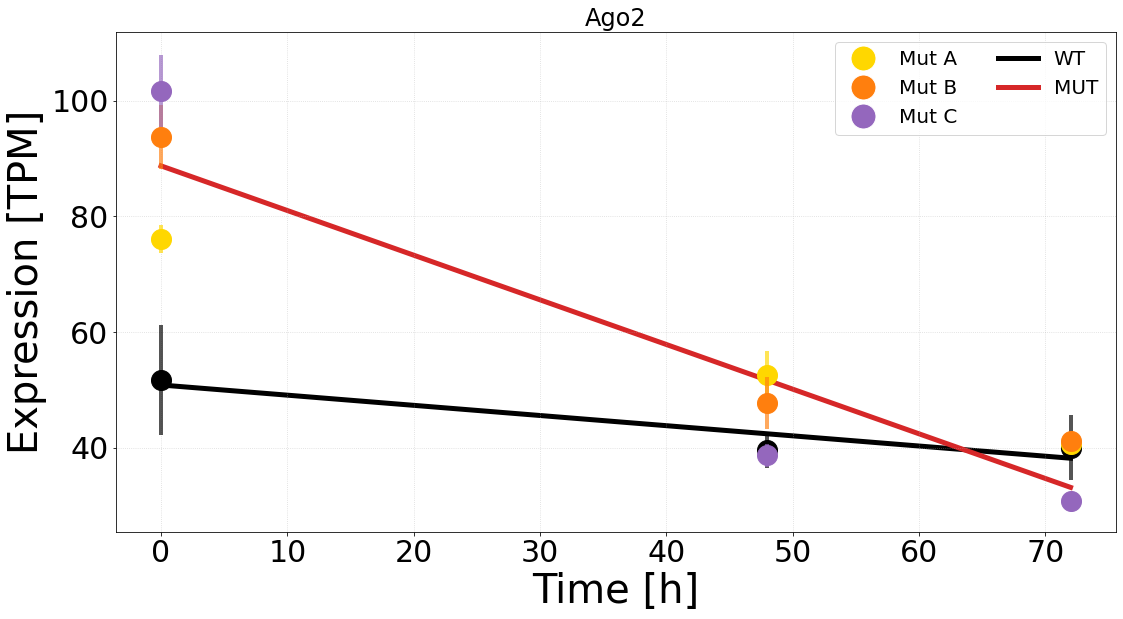

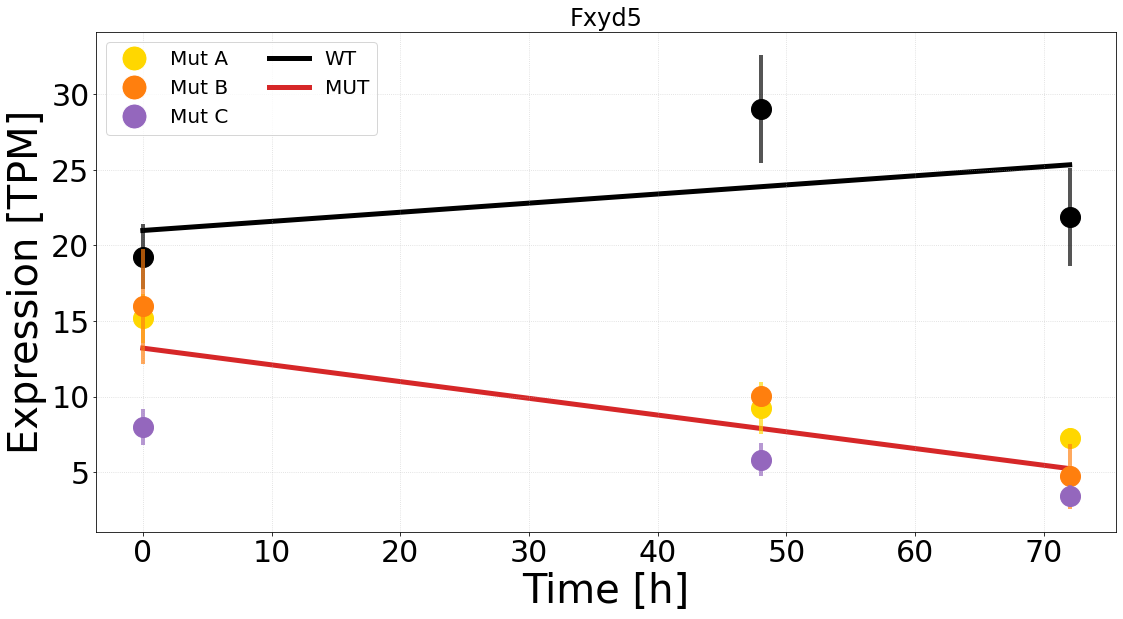

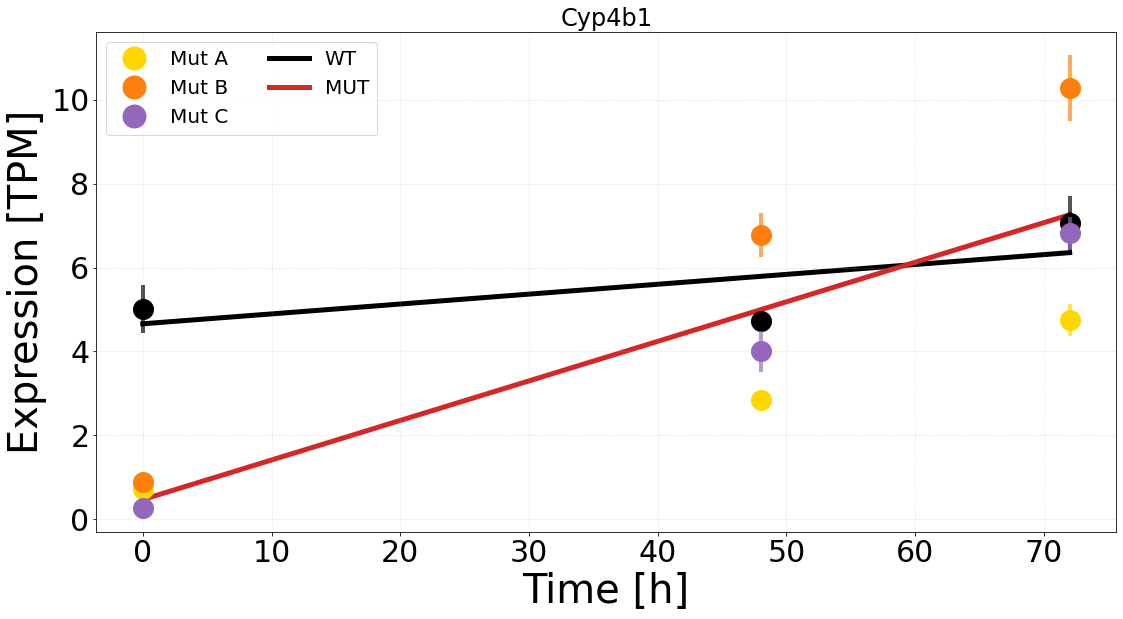

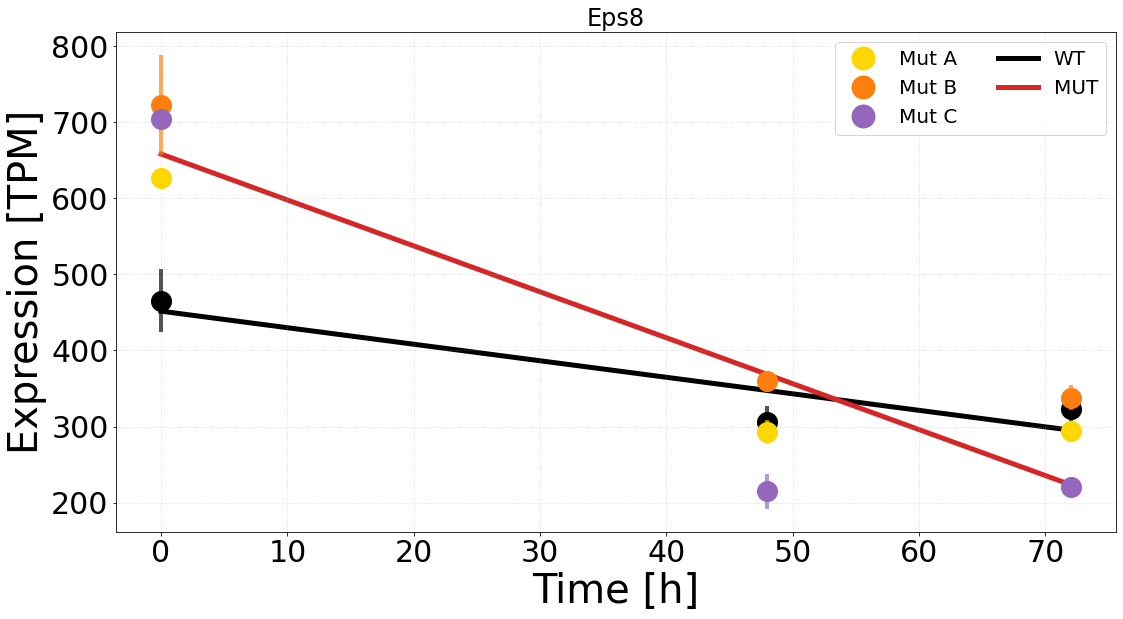

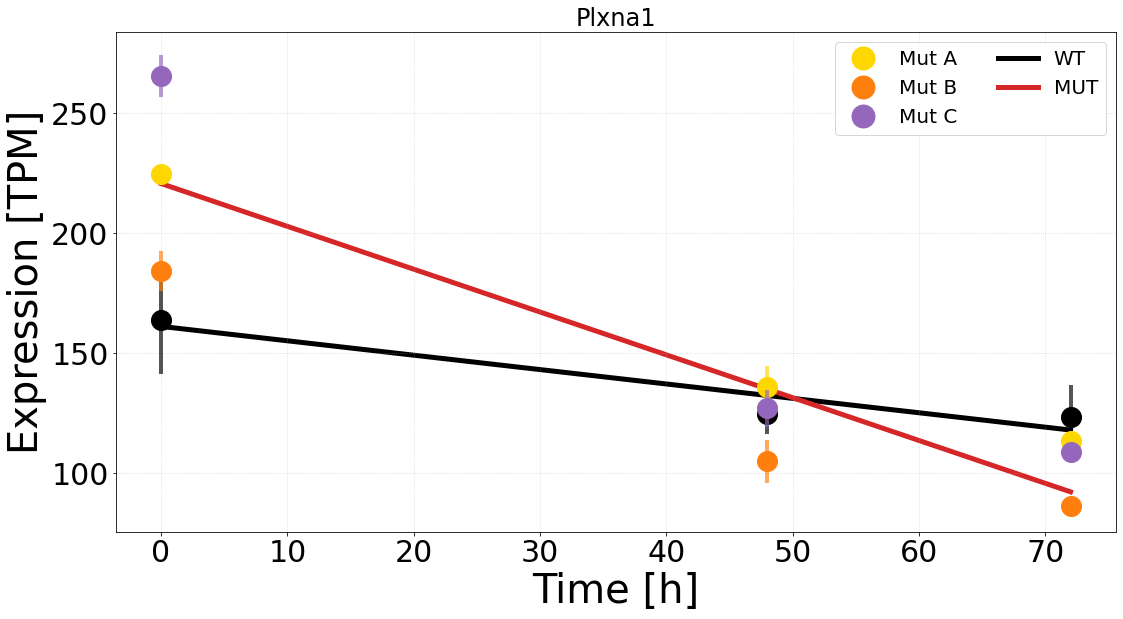

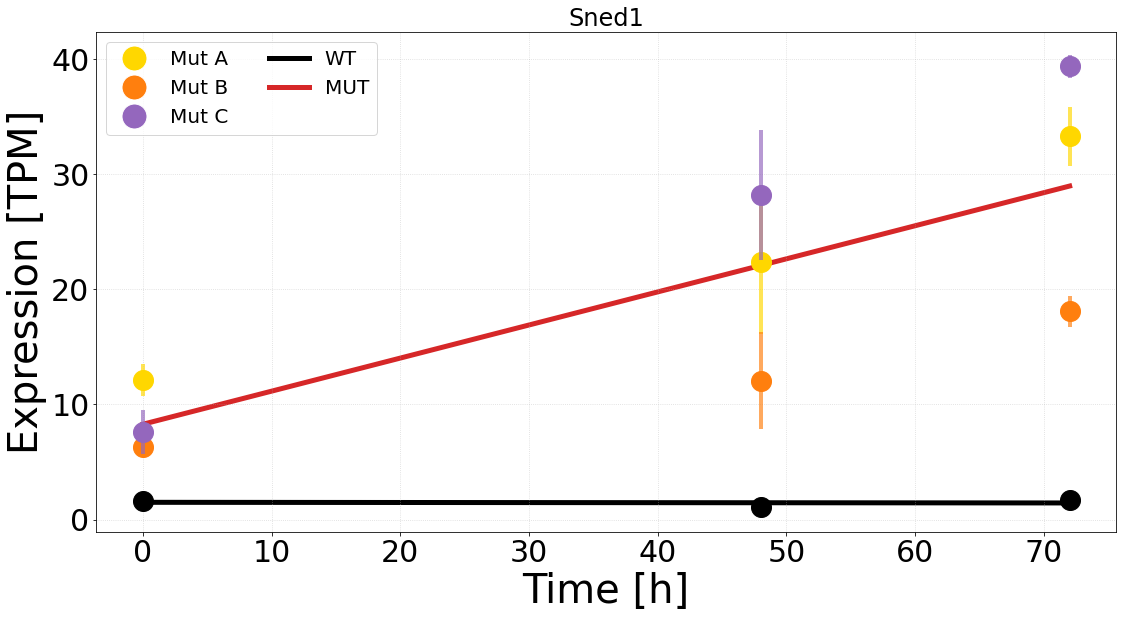

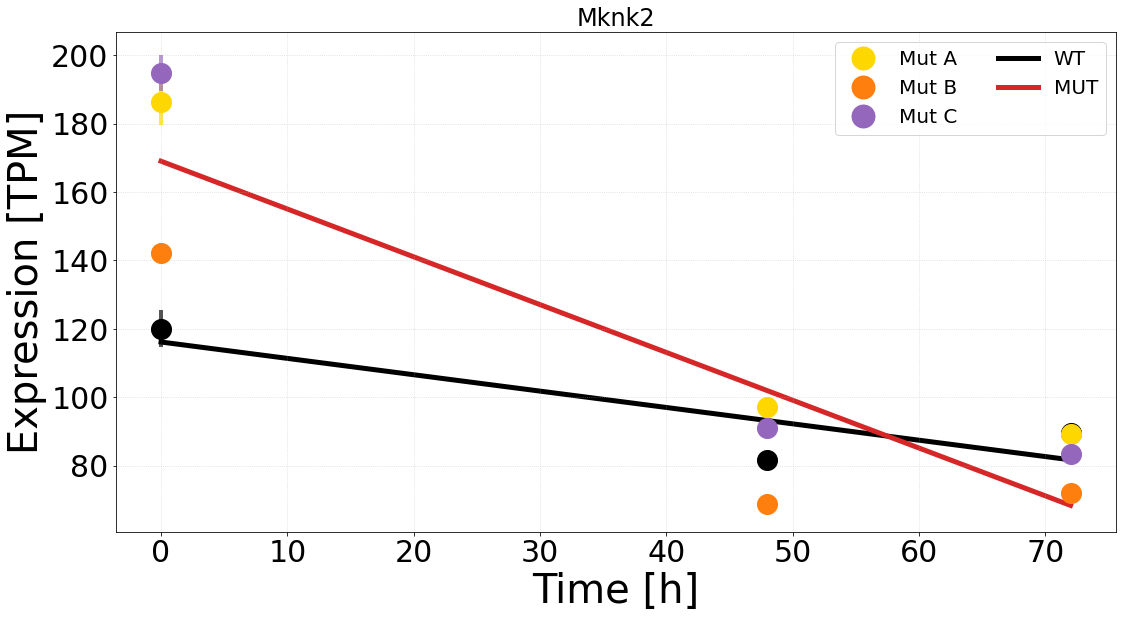

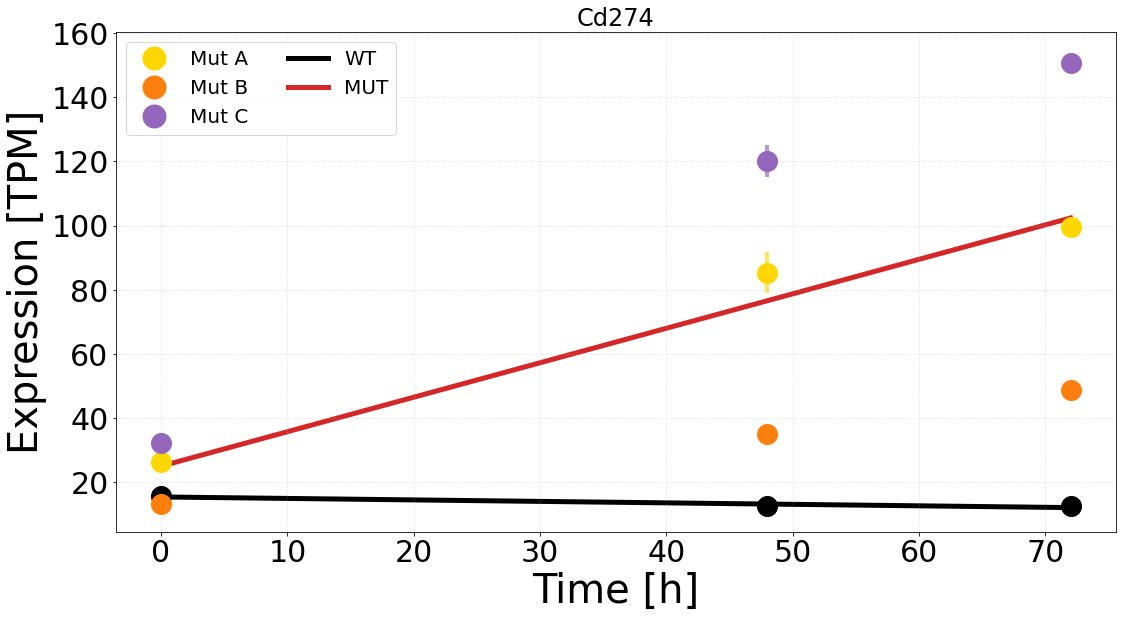

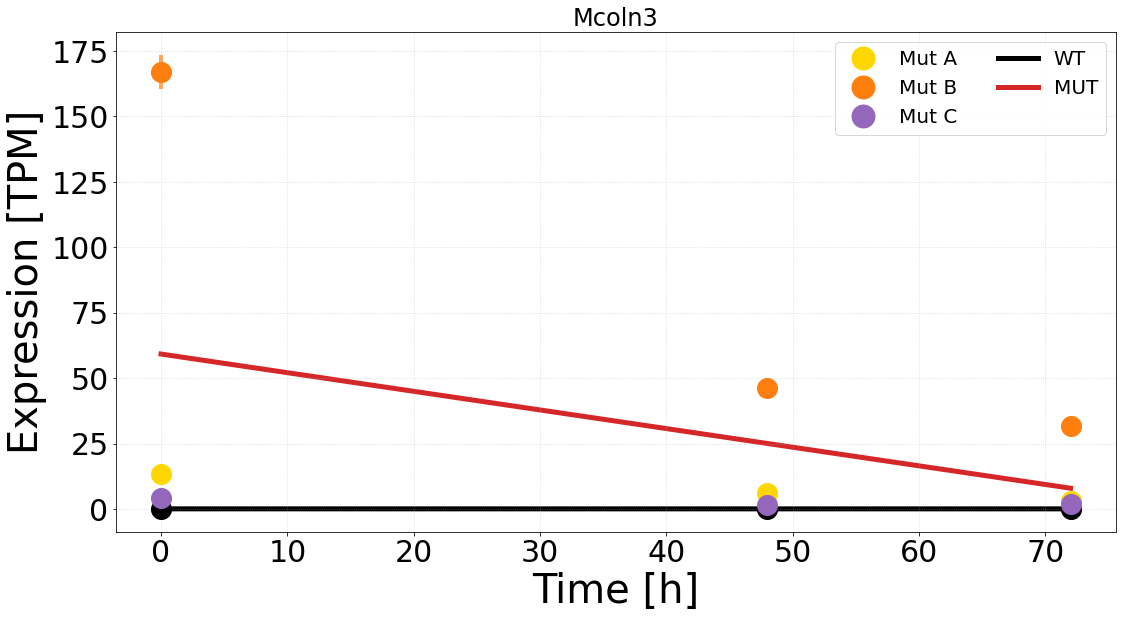

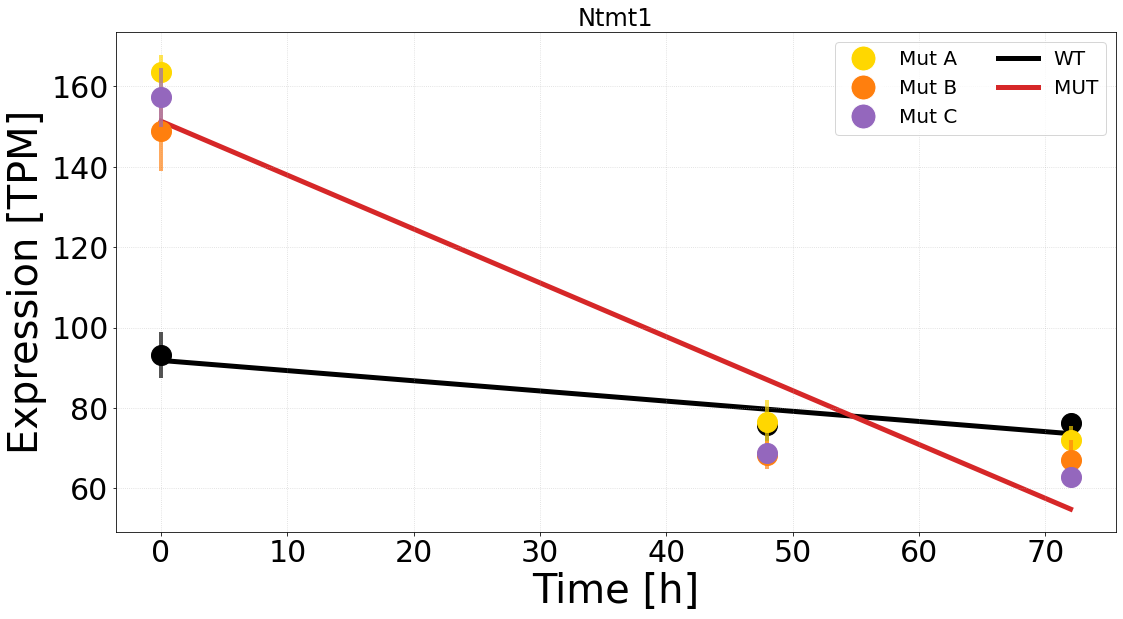

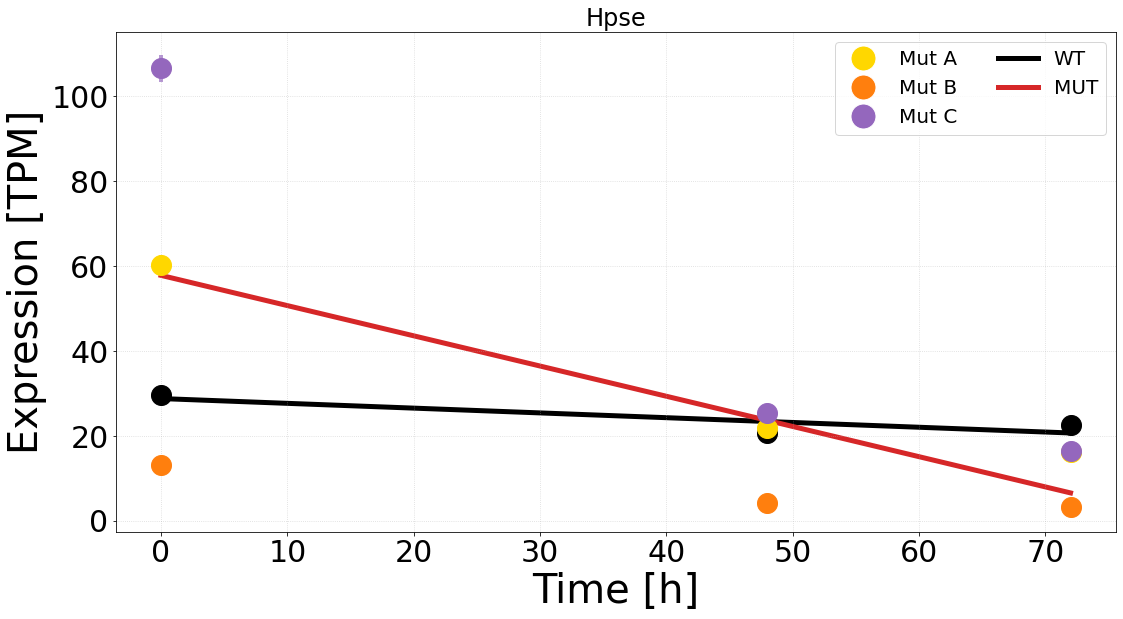

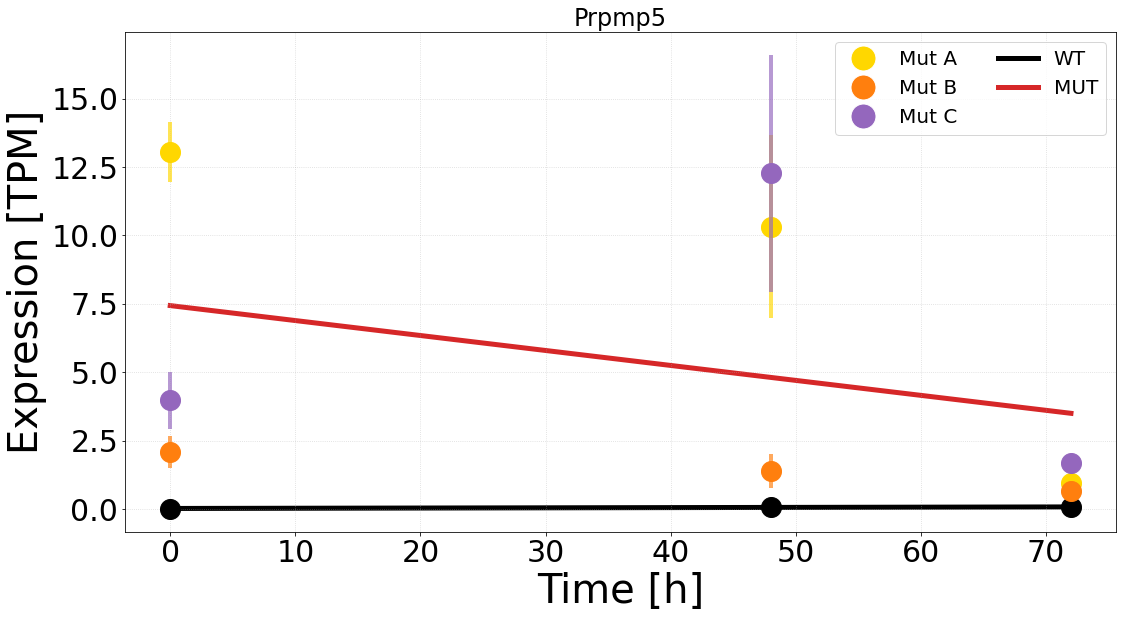

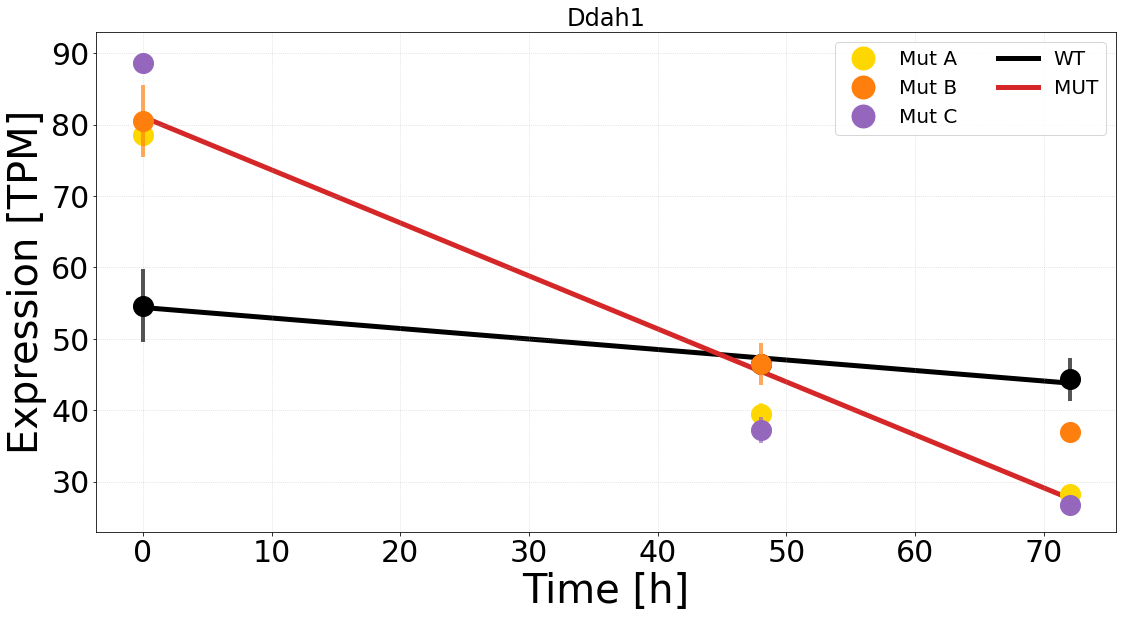

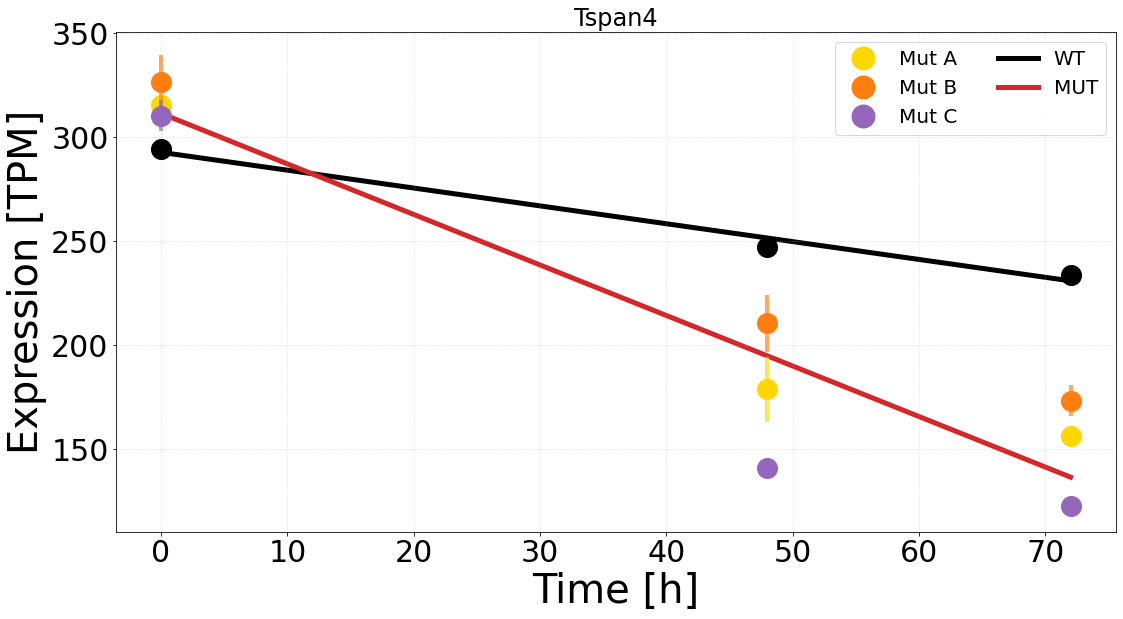

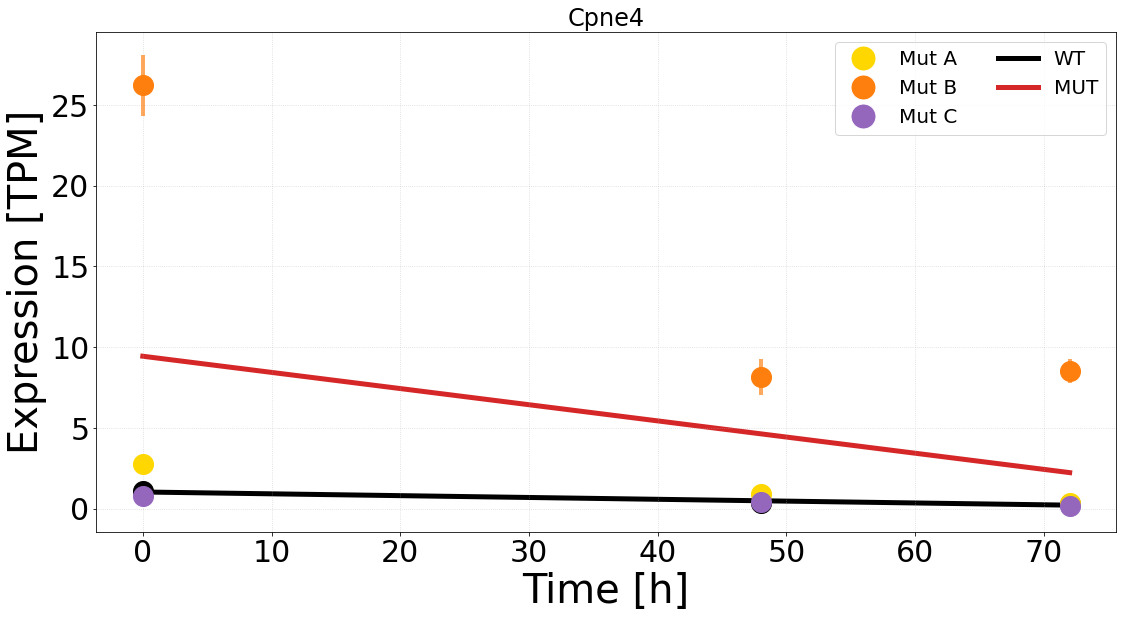

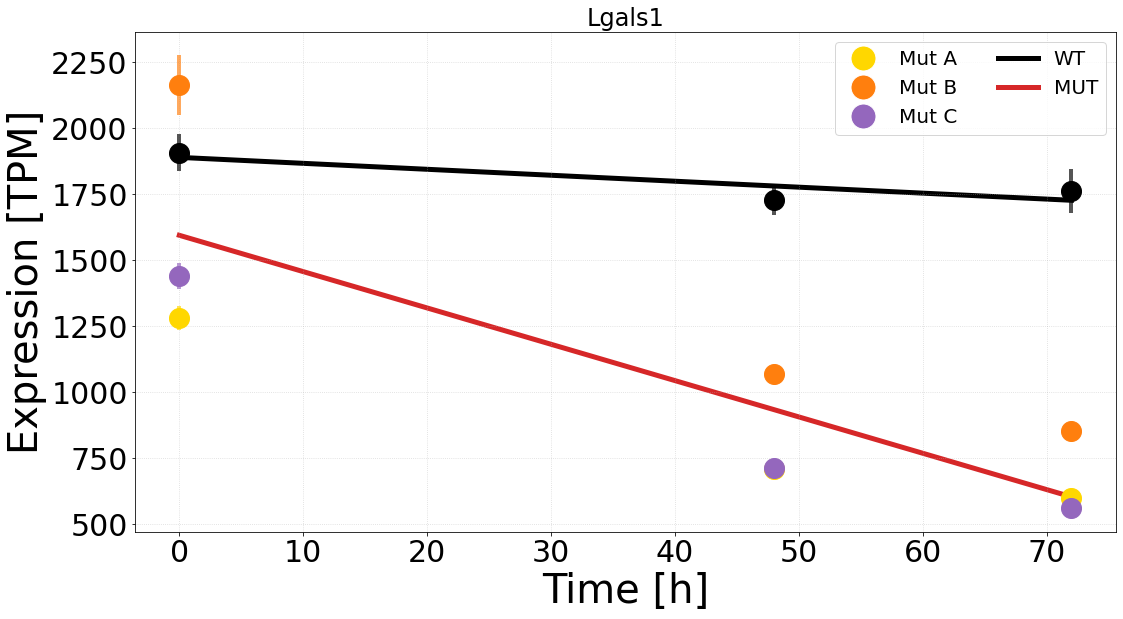

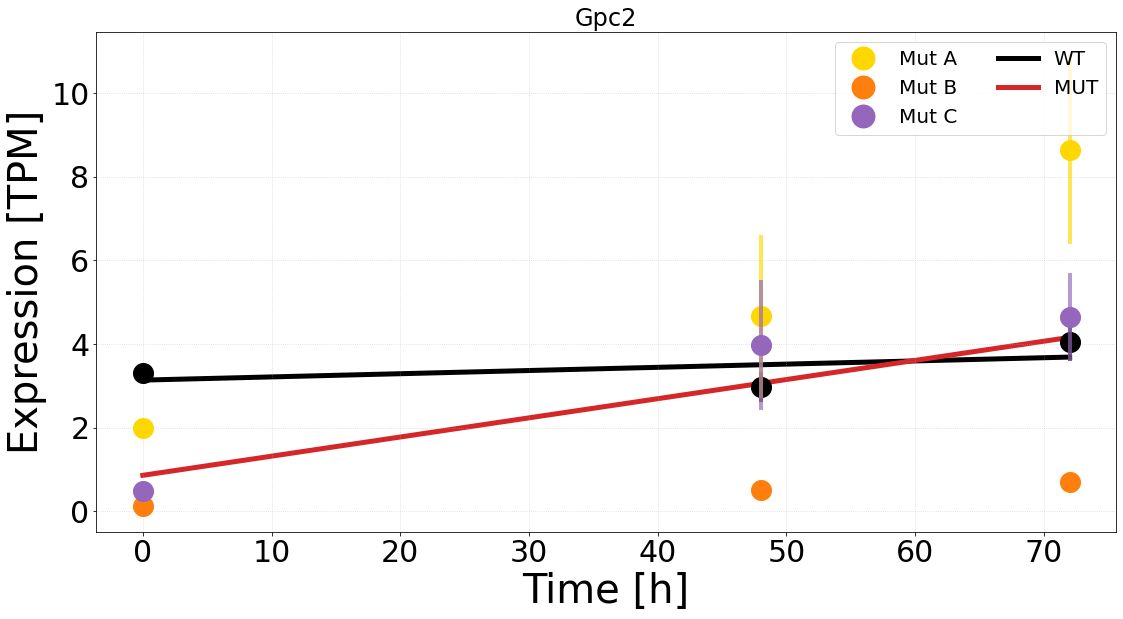

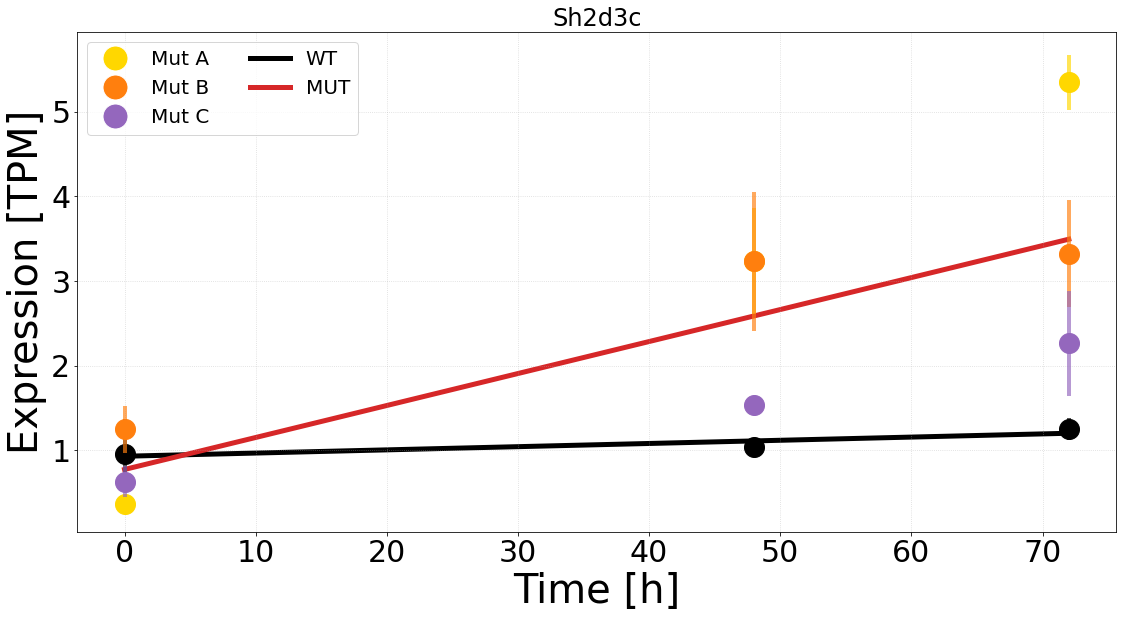

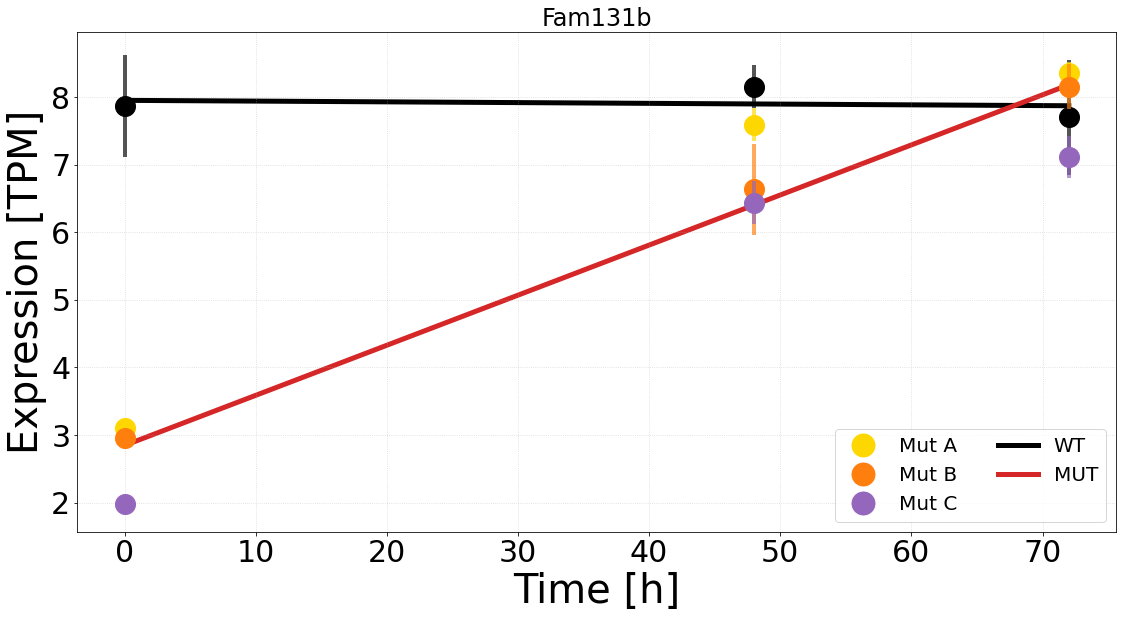

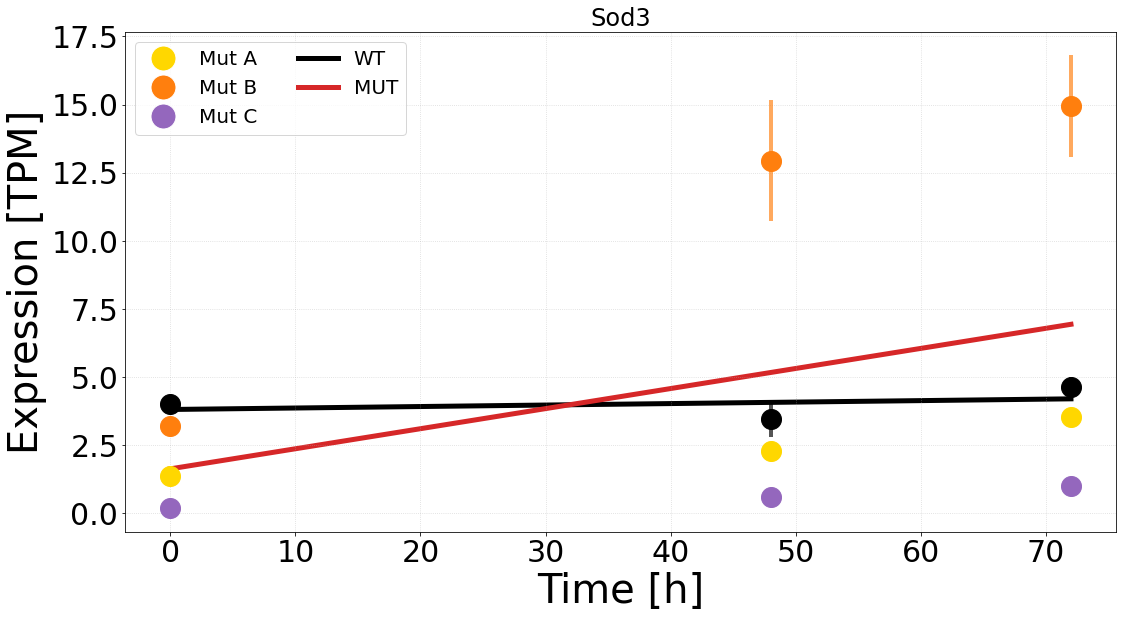

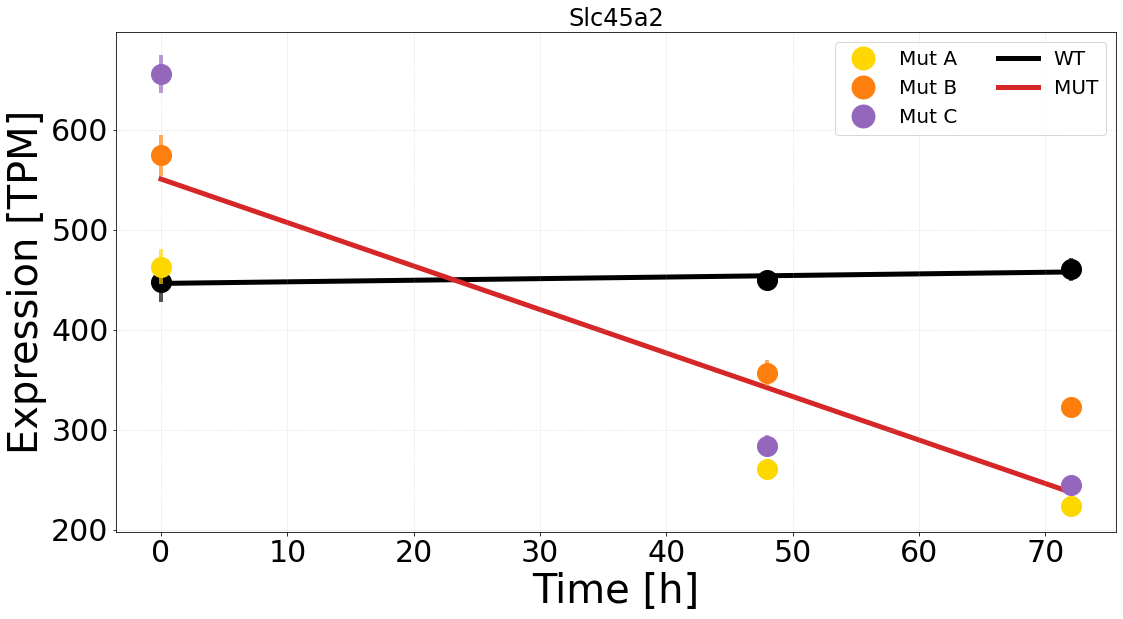

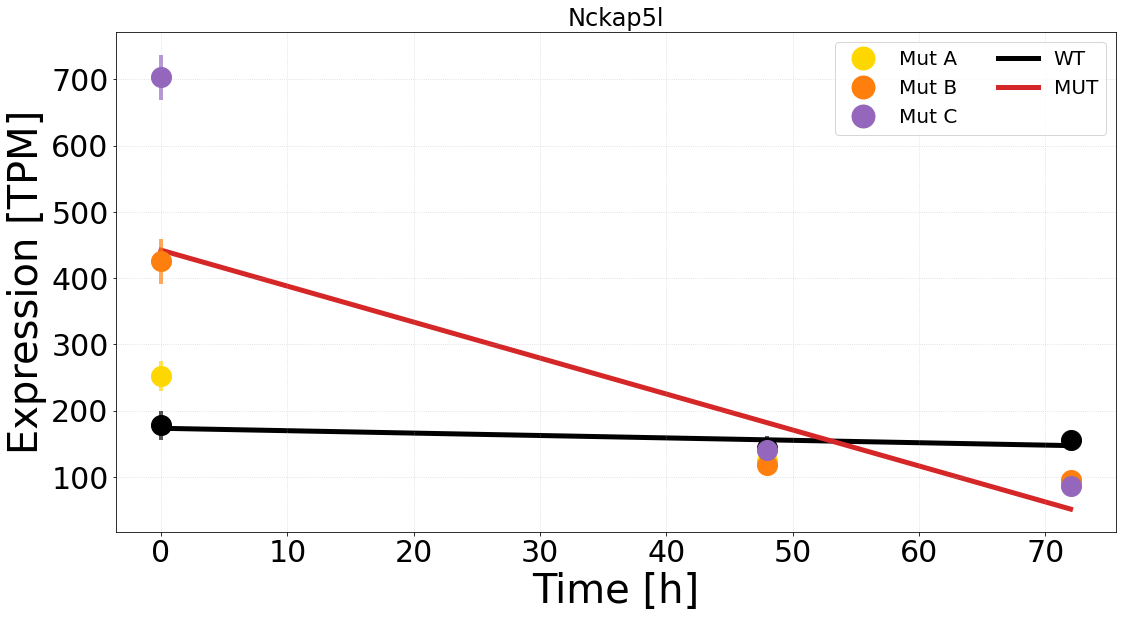

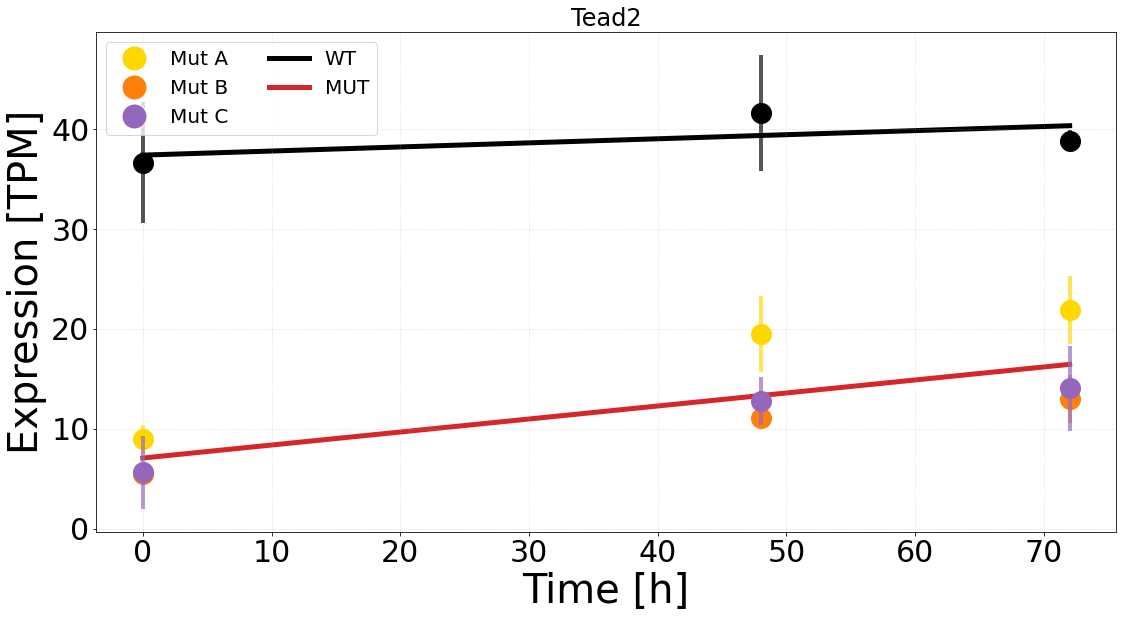

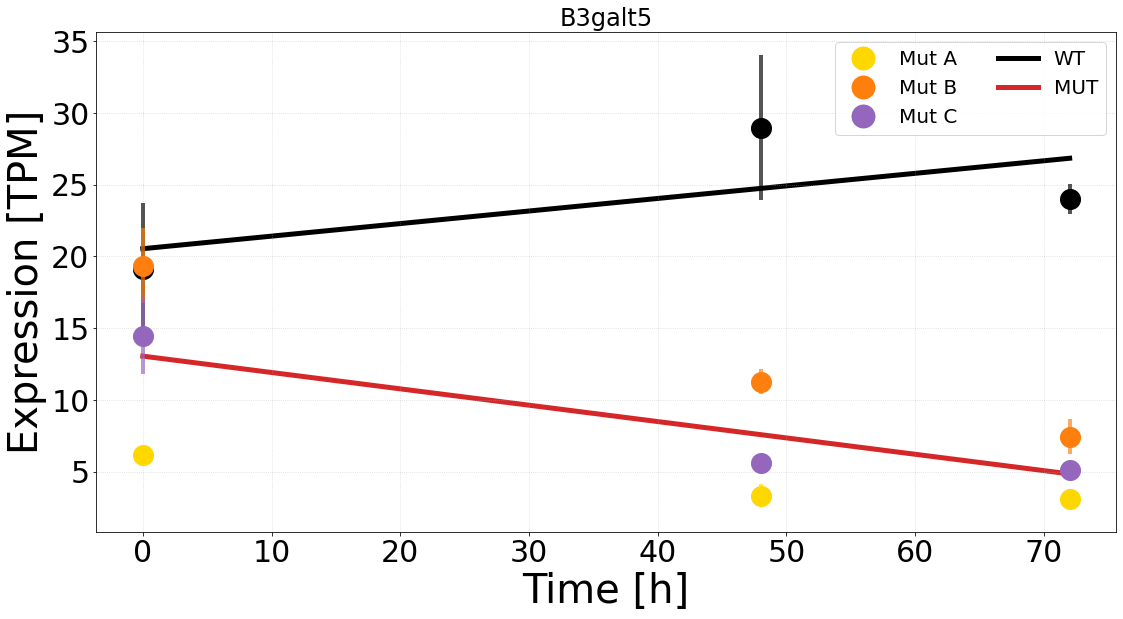

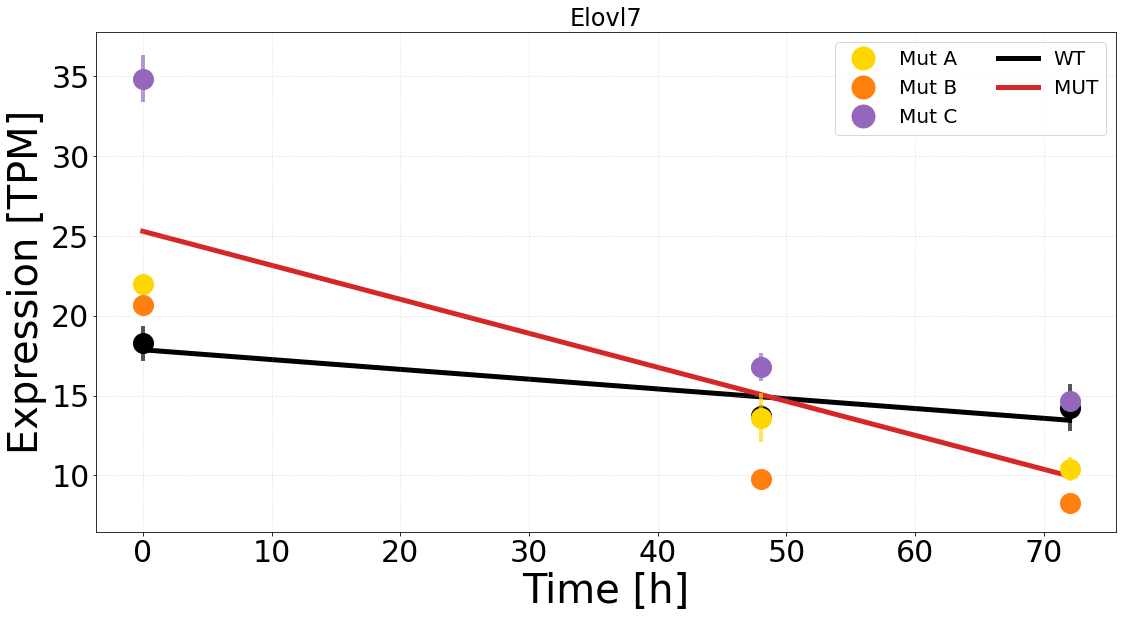

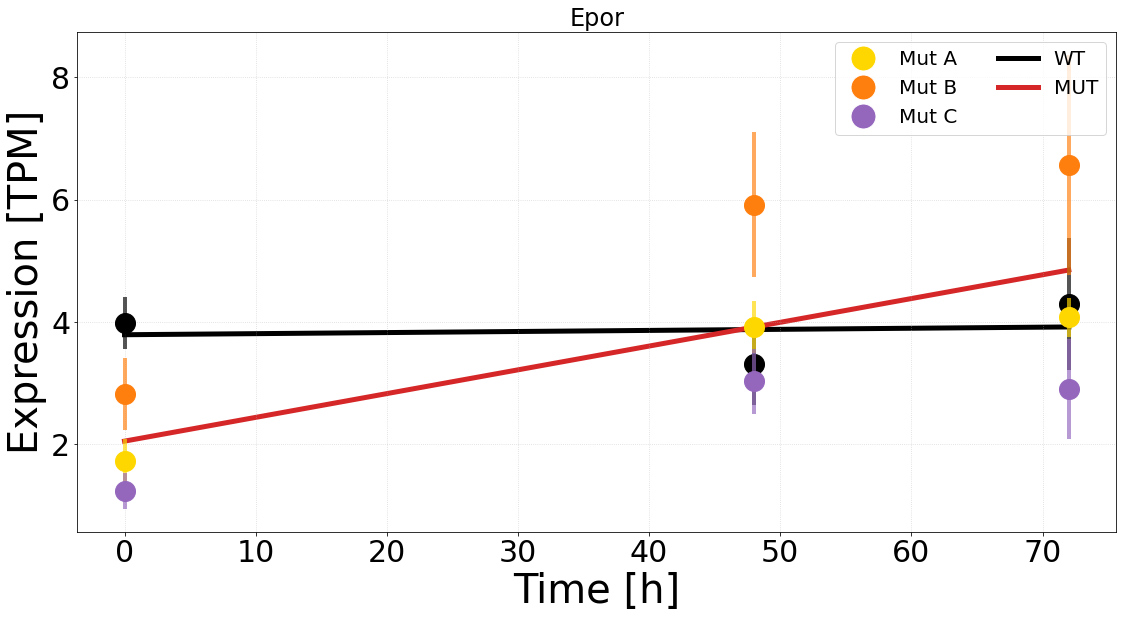

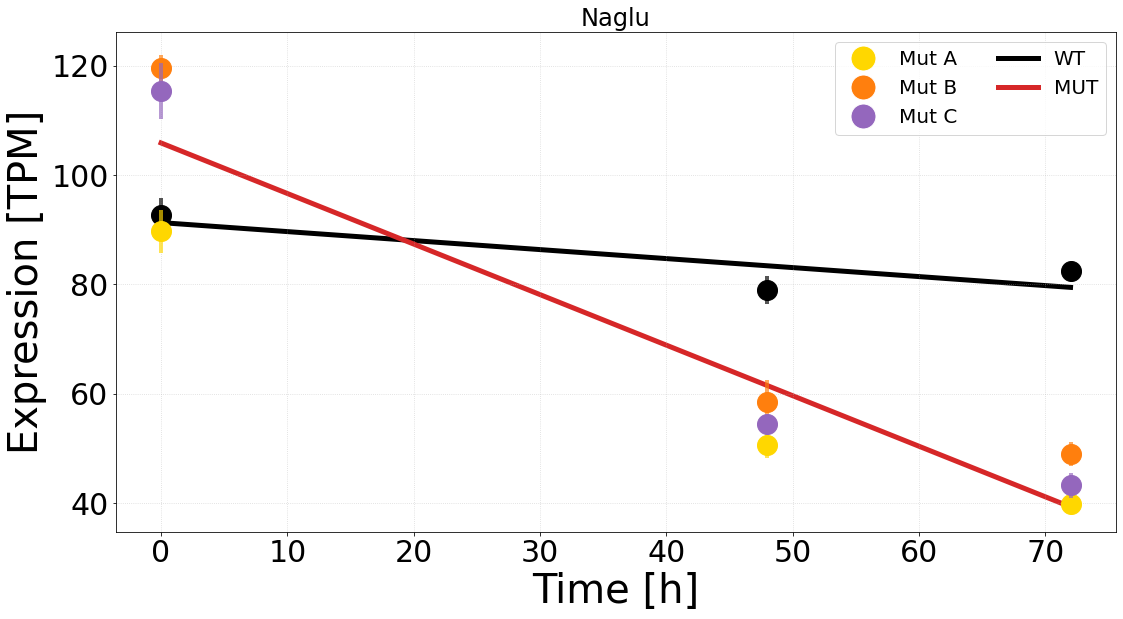

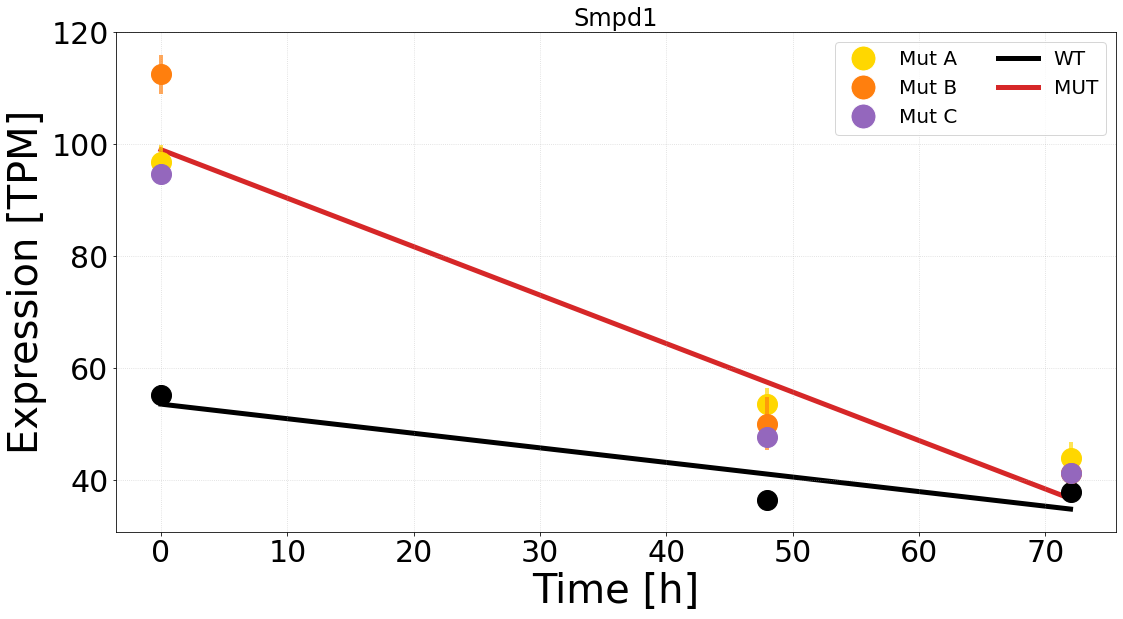

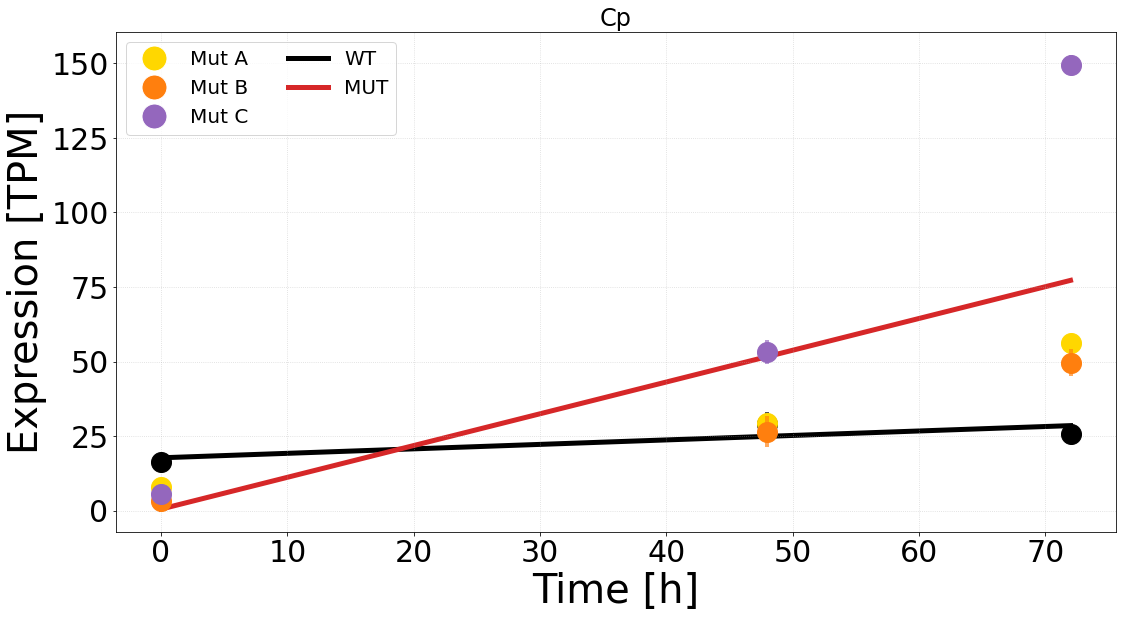

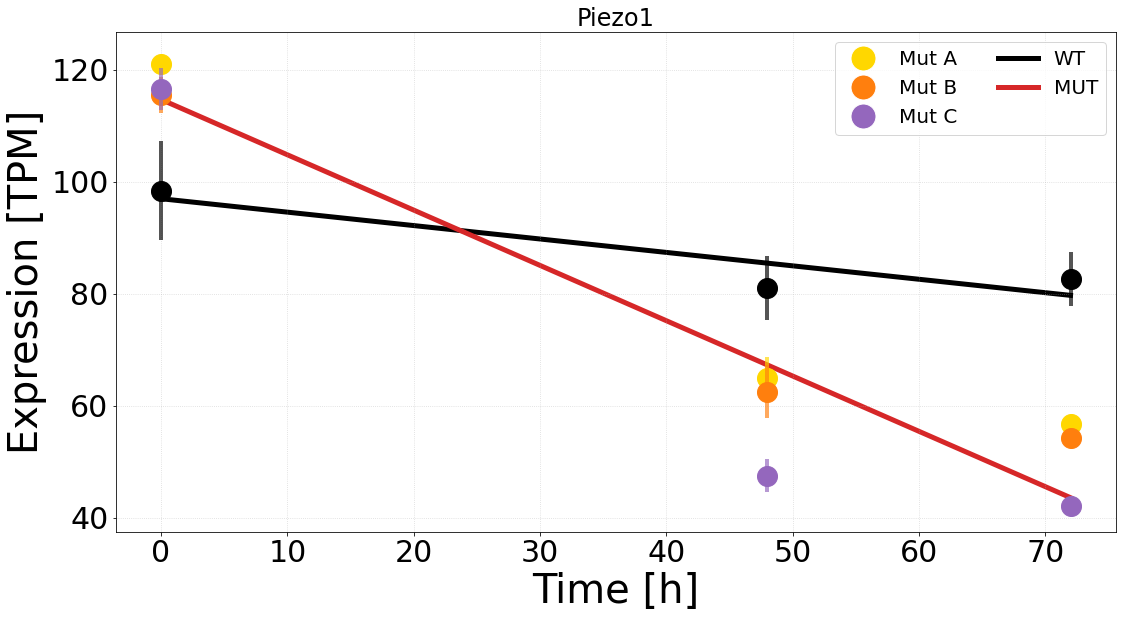

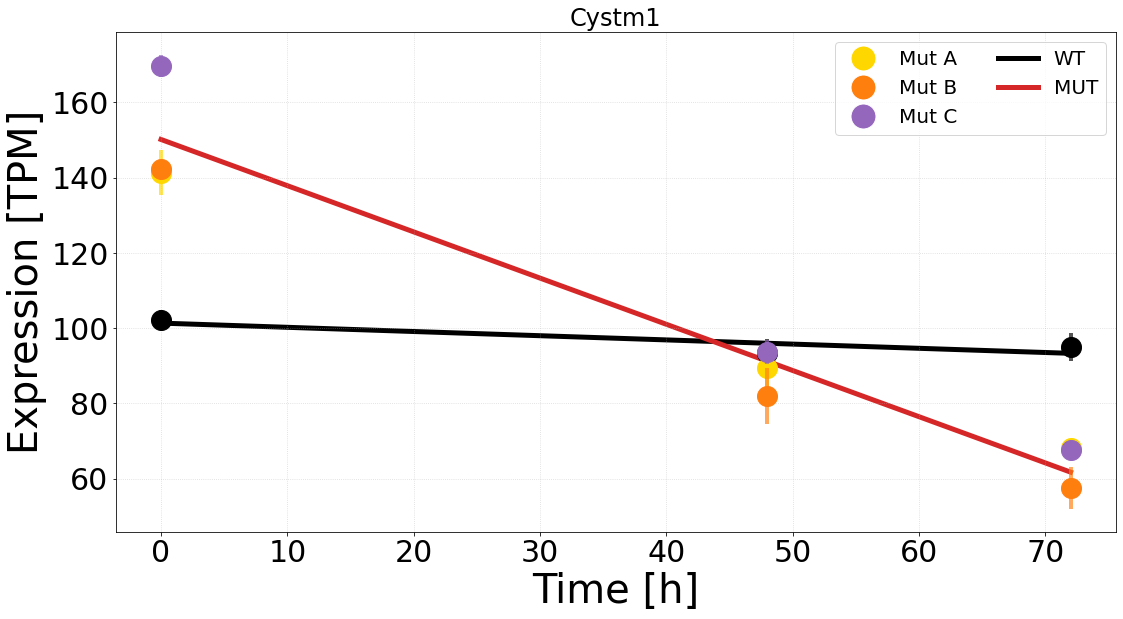

In [17]:
expression_labels = expression.columns
wt_labels = [label for label in simple_expression.columns if 'WT' in label]
mut_labels = [label for label in simple_expression.columns if 'MUT' in label]
fitted_change_dict = {}

for ensembl in list_five:
    gene_name = annotation.loc[ensembl]['ext_gene']
    ensembl_trajectory = []; ensembl_times = []
    fitted_change_dict[gene_name] = []
    
    for mouse in mice:
        plotting_means = []
        plotting_stds = []
        
        for time in times:
            working_labels = [label for label in expression_labels if mouse in label and time in label]
            values = expression.loc[ensembl, working_labels]
            plotting_means.append(numpy.mean(values))
            plotting_stds.append(numpy.std(values))
            
            for value in values.to_list():
                ensembl_trajectory.append(value)
                ensembl_times.append(int(time.split('h')[0]))
            
        # plot data
        if mouse == 'a3922':
            the_color = 'black'
        elif mouse == 'a4774':
            the_color = 'gold'
        elif mouse == 'a4775':
            the_color = 'tab:orange'
        elif mouse == 'a4776':
            the_color = 'tab:purple'
        else:
            print('error')
        matplotlib.pyplot.errorbar(numerical_times, plotting_means, yerr=plotting_stds, color=the_color, lw=0, elinewidth=4, alpha=2/3)
        matplotlib.pyplot.plot(numerical_times, plotting_means, 'o', color=the_color, ms=20)
            
    # fit and visualize trend
    x = ensembl_times[:9]
    y = ensembl_trajectory[:9]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    newx = numpy.arange(0, 72+1, 1)
    newy = slope*newx + intercept
    matplotlib.pyplot.plot(newx, newy, '-', color='black', lw=5, zorder=0)
    # store info for z-score heatmap
    d = slope*numpy.array(numerical_times) + intercept
    for element in d:
        fitted_change_dict[gene_name].append(element)
    
    x = ensembl_times[9:]
    y = ensembl_trajectory[9:]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    newx = numpy.arange(0, 72+1, 1)
    newy = slope*newx + intercept
    matplotlib.pyplot.plot(newx, newy, '-', color='tab:red', lw=5, zorder=0)
    
    # store info for z-score heatmap
    d = slope*numpy.array(numerical_times) + intercept
    for element in d:
        fitted_change_dict[gene_name].append(element)
        
    # define legend elements
    legend_elements = [
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='gold', markersize=25),
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='tab:orange', markersize=25),
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='tab:purple', markersize=25),
        
        matplotlib.lines.Line2D([0], [0], color='black', ls='-', lw=5),
        matplotlib.lines.Line2D([0], [0], color='tab:red', ls='-', lw=5)      
]
    matplotlib.pyplot.legend(legend_elements, ['Mut A', 'Mut B', 'Mut C', 'WT', 'MUT'], ncol=2)
    
    # close figure
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.title(gene_name)
    matplotlib.pyplot.xlabel('Time [h]')
    matplotlib.pyplot.ylabel('Expression [TPM]')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

## 4.3. generate heatmap on z-score

In [18]:
df = pandas.DataFrame(fitted_change_dict)
tdf = df.transpose()
tdf.columns = simple_expression.columns
tdf.head()

,WT_0h,WT_48h,WT_72h,MUT_0h,MUT_48h,MUT_72h
Ago2,50.814126,42.368701,38.145989,88.717597,51.642100,33.104352
Fxyd5,20.991727,23.890167,25.339387,13.207725,7.890148,5.231360
Cyp4b1,4.658109,5.789359,6.354984,0.466116,4.994237,7.258297
Eps8,451.639546,347.363253,295.225106,658.247750,368.426231,223.515471
Plxna1,161.058867,132.278600,117.888467,220.565559,134.945100,92.134871


In [19]:
# retrieve x and y for volcano plot
volcanox = []; volcanoy = []
for gene_name in tdf.index:
    average_expression = numpy.mean(numpy.log2(tdf.loc[gene_name, :]))
    fc_wt = (tdf.loc[gene_name, 'WT_72h'] + 1) / (tdf.loc[gene_name, 'WT_0h'] + 1)
    fc_mut = (tdf.loc[gene_name, 'MUT_72h'] + 1) / (tdf.loc[gene_name, 'MUT_0h'] + 1)
    delta = numpy.log2(fc_mut) - numpy.log2(fc_wt)
    
    volcanox.append(delta); volcanoy.append(average_expression)

In [20]:
zscore_df = scipy.stats.zscore(tdf, axis=1)
zscore_df.head()

,WT_0h,WT_48h,WT_72h,MUT_0h,MUT_48h,MUT_72h
Ago2,0.000842,-0.463734,-0.696023,2.085886,0.046389,-0.973360
Fxyd5,0.629206,1.001395,1.187489,-0.370338,-1.053168,-1.394584
Cyp4b1,-0.120899,0.400965,0.661897,-2.054735,0.034162,1.078610
Eps8,0.440420,-0.313650,-0.690685,1.934500,-0.161334,-1.209251
Plxna1,0.444608,-0.269705,-0.626862,1.921538,-0.203524,-1.266055


In [21]:
zscore_df.columns

Index(['WT_0h', 'WT_48h', 'WT_72h', 'MUT_0h', 'MUT_48h', 'MUT_72h'], dtype='object')

In [22]:
zscore_df = zscore_df[['MUT_0h', 'MUT_48h', 'MUT_72h','WT_0h', 'WT_48h', 'WT_72h']]
zscore_df.head()

,MUT_0h,MUT_48h,MUT_72h,WT_0h,WT_48h,WT_72h
Ago2,2.085886,0.046389,-0.973360,0.000842,-0.463734,-0.696023
Fxyd5,-0.370338,-1.053168,-1.394584,0.629206,1.001395,1.187489
Cyp4b1,-2.054735,0.034162,1.078610,-0.120899,0.400965,0.661897
Eps8,1.934500,-0.161334,-1.209251,0.440420,-0.313650,-0.690685
Plxna1,1.921538,-0.203524,-1.266055,0.444608,-0.269705,-0.626862


In [23]:
print(numpy.max(zscore_df.max()))
print(numpy.min(zscore_df.min()))

top = 2.5; bottom = -2.5
top_white = 0.5; bottom_white = -0.5

2.088614356888797
-2.1266925132785732


In [24]:
# edited from https://stackoverflow.com/questions/59270751/how-to-make-a-diverging-color-bar-with-white-space-between-two-values-matplotlib
p = [bottom, bottom_white, top_white, top]
f = lambda x: numpy.interp(x, p, [0, 0.5, 0.5, 1])
new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('map_white', list(zip(numpy.linspace(0,1), matplotlib.pyplot.cm.bwr(f(numpy.linspace(min(p), max(p)))))))

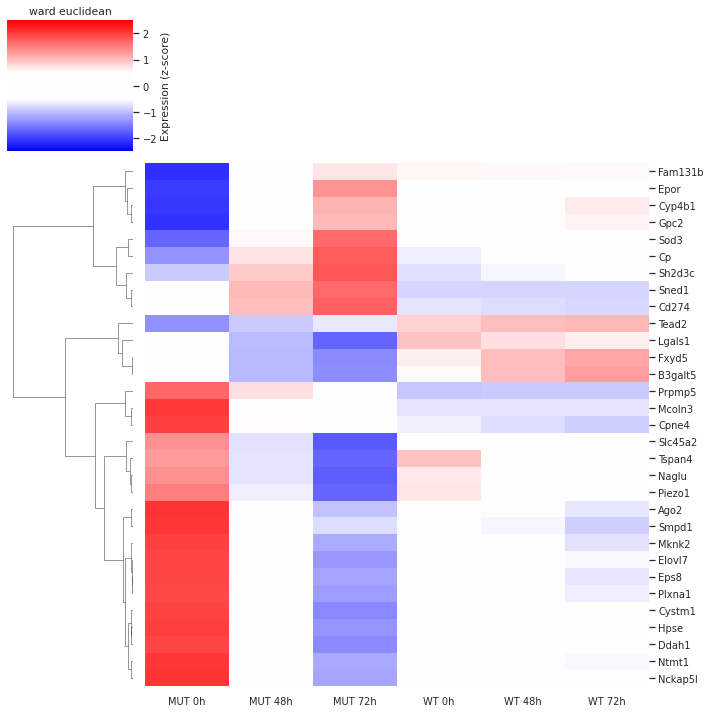

In [25]:
linkage_method = 'ward'
distance_metric = 'euclidean'
seaborn.set(font_scale=0.9)

seaborn.clustermap(zscore_df, cmap=new_cmap, col_cluster=False, vmin=bottom, vmax=top, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['MUT 0h', 'MUT 48h', 'MUT 72h', 'WT 0h', 'WT 48h', 'WT 72h'], cbar_kws={'label':'Expression (z-score)'})

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

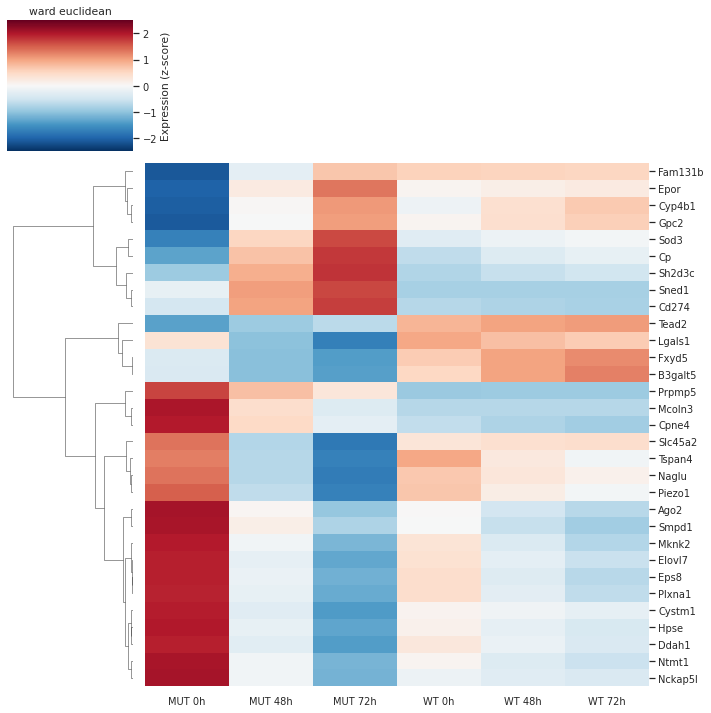

In [26]:
# just a different visualization of the same data
linkage_method = 'ward'
distance_metric = 'euclidean'
seaborn.set(font_scale=0.9)

seaborn.clustermap(zscore_df, cmap='RdBu_r', col_cluster=False, vmin=bottom, vmax=top, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['MUT 0h', 'MUT 48h', 'MUT 72h', 'WT 0h', 'WT 48h', 'WT 72h'], cbar_kws={'label':'Expression (z-score)'})

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [27]:
seaborn.reset_orig()
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

## 4.4. pseudo volcano plot

Ago2	-0.991	5.589	gray
Fxyd5	-1.449	3.787	tab:blue
Cyp4b1	2.115	1.917	tab:red
Eps8	-0.942	8.526	gray
Plxna1	-0.803	7.108	gray
Sned1	1.724	2.340	tab:red
Mknk2	-0.791	6.654	gray
Cd274	2.312	4.812	tab:red
Mcoln3	-2.740	0.256	tab:blue
Ntmt1	-1.132	6.417	tab:blue
Hpse	-2.503	4.482	tab:blue
Prpmp5	-0.986	-1.154	gray
Ddah1	-1.213	5.570	tab:blue
Tspan4	-0.843	7.834	gray
Cpne4	-0.951	0.560	gray
Lgals1	-1.273	10.363	tab:blue
Gpc2	1.291	1.466	tab:red
Sh2d3c	1.152	0.517	tab:red
Fam131b	1.268	2.695	tab:red
Sod3	1.481	1.982	tab:red
Slc45a2	-1.247	8.647	tab:blue
Nckap5l	-2.840	7.319	tab:blue
Tead2	1.007	4.408	tab:red
B3galt5	-1.638	3.773	tab:blue
Elovl7	-0.879	3.949	gray
Epor	0.901	1.856	gray
Naglu	-1.209	6.195	tab:blue
Smpd1	-0.801	5.649	gray
Cp	5.019	4.112	tab:red
Piezo1	-1.097	6.281	tab:blue
Cystm1	-1.150	6.580	tab:blue


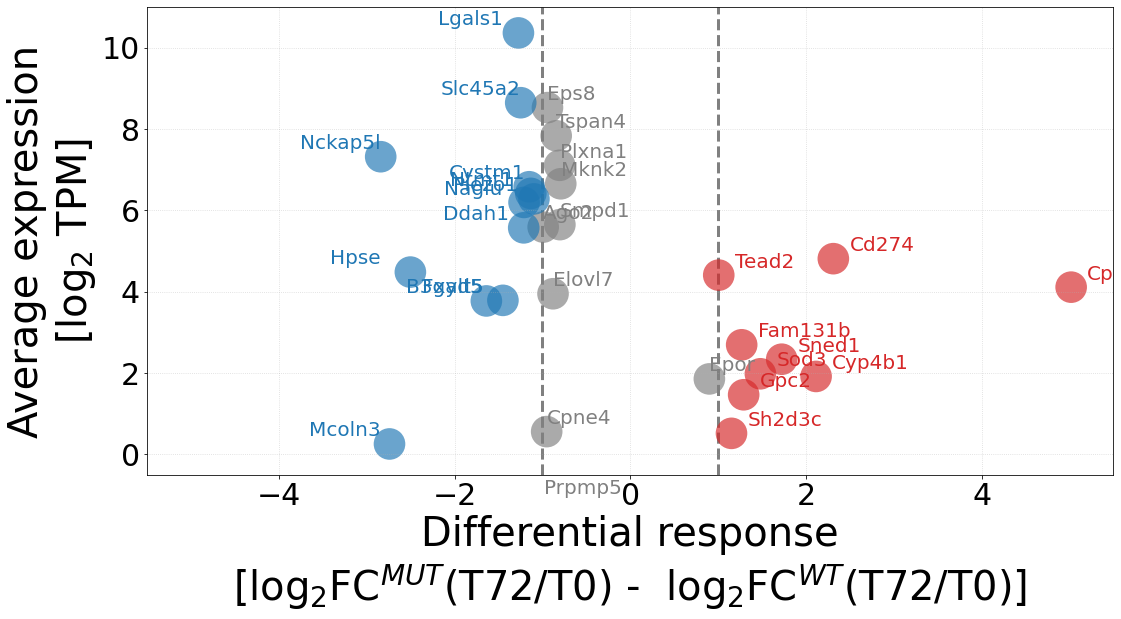

In [28]:
gene_names = tdf.index

for i in range(len(volcanox)):
    
    if -1 <= volcanox[i] <= 1:
        the_color = 'gray'
        matplotlib.pyplot.text(volcanox[i], volcanoy[i]+(11.5/60), gene_names[i], color=the_color)
    elif volcanox[i] > 1:
        the_color = 'tab:red'
        matplotlib.pyplot.text(volcanox[i]+(11/60), volcanoy[i]+(11.5/60), gene_names[i], color=the_color)
    elif volcanox[i] < -1:
        the_color = 'tab:blue'
        matplotlib.pyplot.text(volcanox[i]-(11/12), volcanoy[i]+(11.5/60), gene_names[i], color=the_color)
    else:
        print(volcanox[i])
        print('error')
        
    # finally plotting the dot
    matplotlib.pyplot.scatter(volcanox[i], volcanoy[i], s=1000, c=the_color, alpha=2/3, edgecolor='none')
    
    # printing for interpretation
    if the_color == 'tab:blue':
        printing_color = 'blue'
    elif the_color == 'tab:red':
        printing_color = 'red'
    else:
        printing_color = 'grey'
    message = '\t'.join([gene_names[i], '{:.3f}'.format(volcanox[i]), '{:.3f}'.format(volcanoy[i]), the_color])
    print(termcolor.colored(message, printing_color))

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('Differential response\n[log$_2$FC$^{MUT}$(T72/T0) -  log$_2$FC$^{WT}$(T72/T0)]')
matplotlib.pyplot.ylabel('Average expression\n[log$_2$ TPM]')
matplotlib.pyplot.axvline(1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.axvline(-1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.xlim([-5.5, 5.5])
matplotlib.pyplot.ylim([-0.5, 11])
matplotlib.pyplot.tight_layout()

# 5. direct targets analysis

In [29]:
# convert all expression genes into gene names
# intersect with dorothea ---> that is the universe
# then get MITF and response genes
# compute hypergeometric tests for different confidence values

## 5.1. read Dorothea database

In [30]:
dorothea = pandas.read_csv(dorothea_file, sep='\t', index_col=0)
print(dorothea.shape)
dorothea.head()

(386758, 4)


,tf,confidence,target,mor
1,4932411N23Rik,E,Smad4,1
2,4932411N23Rik,E,0610030E20Rik,1
3,4932411N23Rik,E,1700017N19Rik,1
4,4932411N23Rik,E,4931428F04Rik,1
5,4932411N23Rik,E,4932438A13Rik,1


In [31]:
# define gene names for annotation
annotation_gene_names = set(annotation['ext_gene'].to_list())
print('annotation genes: {}'.format(len(annotation_gene_names)))

a = set(dorothea['tf'].to_list())
b = set(dorothea['target'].to_list())
dorothea_genes = a.union(b)
print('dorothea genes: {}'.format(len(dorothea_genes)))


universe = list(annotation_gene_names & dorothea_genes)
print('common universe genes: {}'.format(len(universe)))

annotation genes: 53115
dorothea genes: 17830
common universe genes: 17698


## 5.2. define the set of Mitf direct targets

In [32]:
confidences = ['A', 'B', 'C', 'D', 'E']
direct_targets = dorothea[dorothea['tf'] == 'Mitf']
print(direct_targets.shape)
direct_targets.head()

(37, 4)


,tf,confidence,target,mor
134897,Mitf,A,Acp5,1
134898,Mitf,A,Apex1,1
134899,Mitf,A,Bcl2,1
134900,Mitf,A,Bcl2a1a,-1
134901,Mitf,A,Bcl2a1b,-1


In [33]:
direct_targets_names = direct_targets['target'].to_list()
print(len(direct_targets_names))

37


# 5.3. define the number of responding genes among Mitf direct target genes

In [34]:
print(direct_targets_names[:5])
response_genes = gene_names.to_list()
print(response_genes[:5])

['Acp5', 'Apex1', 'Bcl2', 'Bcl2a1a', 'Bcl2a1b']
['Ago2', 'Fxyd5', 'Cyp4b1', 'Eps8', 'Plxna1']


In [35]:
successes = list(set(direct_targets_names) & set(response_genes))
print(successes)

[]


## 5.4. plot the behaviour of the Mitf direct target genes